<a href="https://colab.research.google.com/github/dr-richard-barker/image-analysis-software-and-R-codes/blob/master/An_Attempt_To_Gauge_Growth_v2_streamlit_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Attempt To Gauge Plant Growth V2 added streamlit attempt
---


## A Rather Unreliable Method of Measuring Plant Growth
I'm going to say right out of the gate that this method has issues. The results I got from this method were terribly inaccurate and I only trust it to give a basic ballpark for the information for plant growth.

That being said, I think there are some very important aspects that are showcased in this notebook, most importantly the plantCV morphology framework which can trace "skeletons" of plants and can measure tons of intresting information about plants. I wanted to put out this as an example of how to use the framework in case one of you are intrested in this type of analysis you have an example to build off of and reference. I also belive that with some better thresholding this method can be more accurate and I want to hear your suggestions on how to improve the program. 

To start I imported plantcv library, the matplotlib library (to make graphs and have some basic image functions) numpy (to be able to edit data arrays effectively), and os (for some of it's file managing functions)

In [ ]:
# Import Libraries 
from plantcv import plantcv as pcv
import matplotlib
import numpy as np
import os
import streamlit as st

# Set debug to the global parameter 
pcv.params.debug = "plot"

## Cropping
I cropped the images from the getgo. Unfortunately, cropping it using list splicing doesn't give the nice box around the area in question like the region of intrest function does. Here I crop out all but the middle most plant that sits right under the B marked with sharpie.

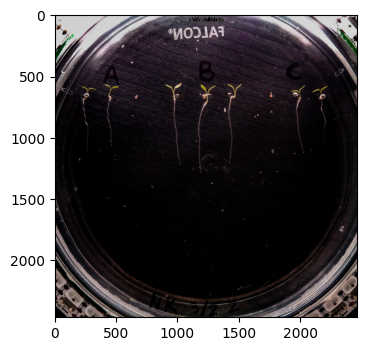

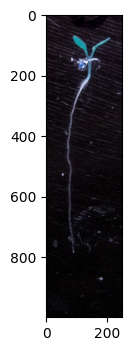

In [ ]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage("../FL_1_ps/FL-1_image00095.jpg")
cropped_img = img[500:1500,1100:1350]
matplotlib.pyplot.imshow(cropped_img)

## Thresholding
At the outset thresholding seems pretty easy. The image itself seems pretty defined so I went ahead with a simple rgb to grayscale conversion and worked from there. 

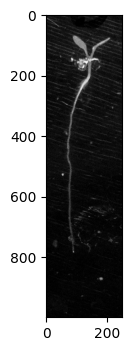

In [ ]:
gray_img = pcv.rgb2gray(cropped_img)

Then things get very hairy. The basic issue that I have with all my plantCV analysis thresholding is that if I threshold too much I lose accuracy as the roots get slowly eaten away due to their darker pixel values. This is exacerbated by the inconsistant lighting in the photos which makes the background in some parts of the image brighter then the area where the roots reside. This is also why I have to crop images out of their parent photos; the lighting in them simply aren't consistant for a one-size fits all thresholding approach. I've included examples. You can see that using the same thresholding settings as the cropped image shortens the lengths of the roots of the leftmost plants considerably.

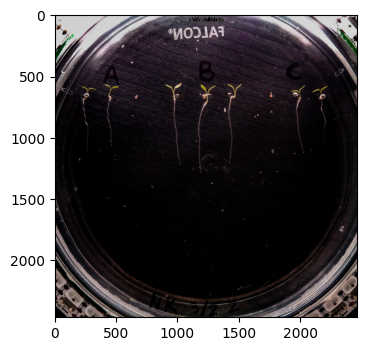

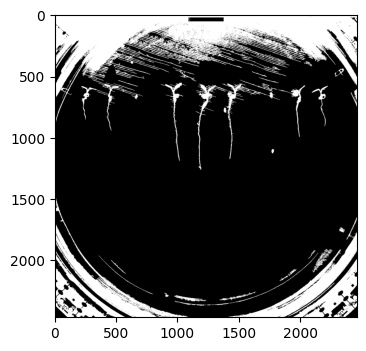

In [ ]:
# Read image 
img, path, filename = pcv.readimage("../FL_1_ps/FL-1_image00095.jpg")

pcv.params.debug = "None"
ba_img = pcv.rgb2gray_hsv(img, channel='v')
s_thresh = pcv.threshold.binary(gray_img=ba_img, threshold=40, max_value=255, object_type='light')
pcv.params.debug = "plot"
ab_fill = pcv.fill(bin_img=s_thresh, size=500)

I also would like to demonstrate in the next two code blocks why I decided to use a lower threshold. You can see that simply bumping the threshold up to 50 creates dark spots around the bottom of the picture where the roots are. Since the next step is a fill step where all the dust specks are filtered, these dark spots lead to parts of the roots being erased which is a big no-no.

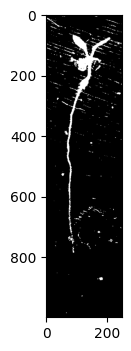

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
pcv.threshold.binary(gray_img=gray_img, threshold=50, max_value=255, object_type='light')

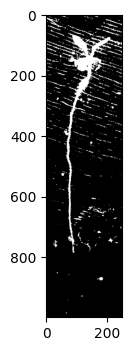

In [ ]:
s_thresh = pcv.threshold.binary(gray_img=gray_img, threshold=35, max_value=255, object_type='light')

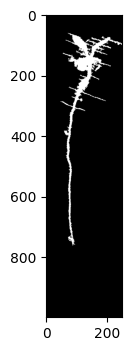

In [ ]:
ab_fill = pcv.fill(bin_img=s_thresh, size=500)

The issue with low thresholding is that the mask now has "hairs" sticking out of them. If I skeletonize it now it leads to the following mess of lines:

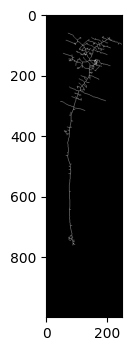

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
pcv.morphology.skeletonize(mask=ab_fill)

To fix that I apply a gaussian blur to hide some of the noise and that seems to allow for much cleaner skeletons.

I want to find some way to plug clean thresholds into this from the start and see what can be achived here. It may lead to much cleaner data. Any help or tips in the right direction in this regard would be immensely helpful.

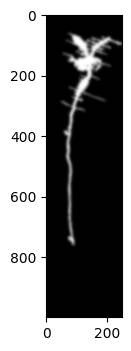

In [ ]:
gaussian_img = pcv.gaussian_blur(img=ab_fill, ksize=(25, 25), sigma_x=0, sigma_y=None)

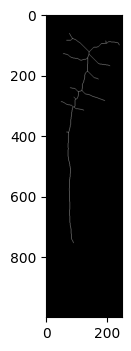

In [ ]:
skeleton = pcv.morphology.skeletonize(mask=gaussian_img)

## Morphology
Here I do some clean up of the skeleton using the prune function before segmenting the image and having the computer determine which parts of the skeleton are the stem/root and which part of the skeleton are the roots. 

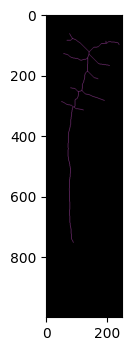

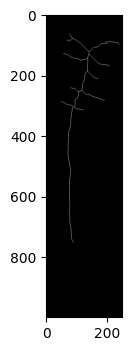

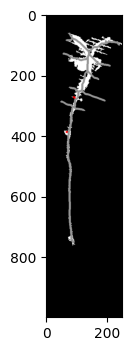

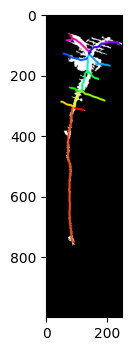

In [ ]:
pruned, seg_img, edge_obj = pcv.morphology.prune(skel_img=skeleton, size=10, mask=ab_fill)

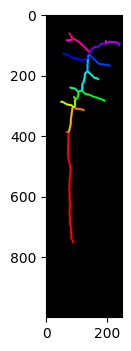

In [ ]:
segmented_img, obj = pcv.morphology.segment_skeleton(skel_img=skeleton)

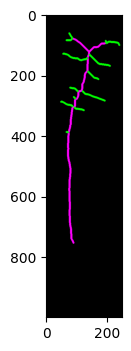

In [ ]:
leaf_obj, ) = pcv.morphology.segment_sort(skel_img=skeleton,
                                                  objects=obj)

Then it's a simple matter of asking the computer to find the length of each segment and outputting them in a value along with an image with the ID of each segment for reference. I wanted the image to be an output to accompany the datavalues measuring the length of the stem sections so I spliced the image with segment ids with the path length images to create a reference image to accompany the data.

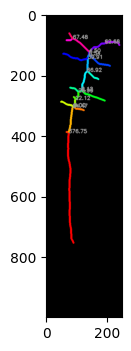

In [ ]:
labeled_img = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                 objects=other_obj)

# Access data stored out from segment_path_length
path_lengths = pcv.outputs.observations['segment_path_length']['value']

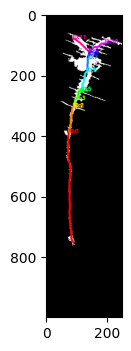

In [ ]:
segmented_img, id_labels = pcv.morphology.segment_id(skel_img=skeleton, 
                                                          objects=other_obj,
                                                          mask=ab_fill)

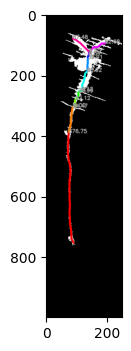

In [ ]:
labeled_img = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                 objects=other_obj)

# Access data stored out from segment_path_length
path_lengths = pcv.outputs.observations['segment_path_length']['value']

In [ ]:
obs = pcv.outputs.observations['segment_path_length
dict(zip(obs['label'], obs['value']))

{'segment_path_length': {'trait': 'segment path length', 'method': 'plantcv.plantcv.morphology.segment_path_length', 'scale': 'pixels', 'datatype': "<class 'list'>", 'value': [376.75483322143555, 84.47056245803833, 0.0, 22.12132030725479, 25.985281229019165, 8.121320307254791, 66.92030984163284, 39.91421353816986, 8.535533845424652, 4.5, 62.68376553058624, 67.4827550649643], 'label': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}


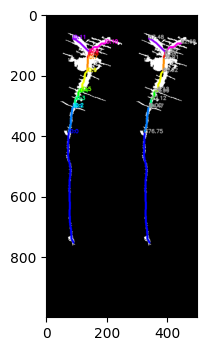

In [ ]:
plot_image = np.concatenate((id_labels, labeled_img), axis=1)
matplotlib.pyplot.imshow(plot_image)
matplotlib.pyplot.savefig("test.png")

## Processing Multiple Images
Once I figured out how everything worked here I created a python script that paged through a directory and precessed every image with a .jpg extension. I've included it below. Basic usage is shown below

```python3 ./dir_rootgrowth.py -i ../FL_1_ps -o ./test > results.txt```

So in this example I direct the -i or --indir (input directory) tag to the folder with all my images. In this case that's the folder "../FL_1_ps". The output folder will collect all the output images (in this case ./test). The program also prints a dictionary the supposed height of all the plants with the name of the original image as the key. Here I went ahead and made the output print directly into a text file named results.txt for convenience.

```python
# Import Libraries 
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import numpy as np
import argparse
import sys, traceback
import os

### Parse command-line arguments
def options():
    parser = argparse.ArgumentParser(description="Imaging processing with opencv")
    parser.add_argument("-i", "--indir", help="Input image file.", required=True)
    parser.add_argument("-o", "--outdir", help="Output directory for image files.", required=False)
    parser.add_argument("-r","--result", help="result file.", required= False )
    parser.add_argument("-w","--writeimg", help="write out images.", default=False, action="store_true")
    parser.add_argument("-D", "--debug", help="can be set to 'print' or None (or 'plot' if in jupyter) prints intermediate images.", default=None)
    args = parser.parse_args()
    return args

def main():
    args = options()
    pcv.params.debug = args.debug #sets plantcv settings to the ones put in by the command line output
    pcv.params.debug_outdir=args.outdir
    
    lengthdict = {} # Create a dictionary to house the values created by each file


    for images in os.listdir(args.indir): # go through each item in a directory
        if images.endswith(".jpg"): # If it is a jpg file do the analysis. If not, don't
 
            # Read image
            img, path, filename = pcv.readimage(filename=args.indir+ "/" + images)
            cropped_img = img[500:1500,1100:1350]

            gray_img = pcv.rgb2gray(cropped_img)
            s_thresh = pcv.threshold.binary(gray_img=gray_img, threshold=35, max_value=255, object_type='light')
            ab_fill = pcv.fill(bin_img=s_thresh, size=500)
            gaussian_img = pcv.gaussian_blur(img=ab_fill, ksize=(25, 25), sigma_x=0, sigma_y=None)
            
            
            skeleton = pcv.morphology.skeletonize(mask=gaussian_img)
            segmented_img, obj = pcv.morphology.segment_skeleton(skel_img=skeleton)
            leaf_obj, other_obj = pcv.morphology.segment_sort(skel_img=skeleton, objects=obj)

            # Access data stored out from segment_path_length
            segmented_img, id_labels = pcv.morphology.segment_id(skel_img=skeleton, objects=other_obj, mask=ab_fill)
            length_labels = pcv.morphology.segment_path_length(segmented_img=segmented_img, objects=other_obj)

            # Access data stored out from segment_path_length
            #pcv.print_results(filename=args.result)
            path_lengths = pcv.outputs.observations['segment_path_length']['value']
            obs = pcv.outputs.observations['segment_path_length']
            #print({filename:dict(zip(obs['label'], obs['value']))})
            lengthdict.update({filename:sum(obs['value'])})

            
            outfile=False
            if args.writeimg == True:
                outfile = args.outdir + "/" + filename
            plot_image = np.concatenate((id_labels, length_labels), axis=1)
            plt.imshow(plot_image)
            plt.savefig(args.outdir + "/" + os.path.splitext(filename)[0] + "_plot.png")
    
    print(lengthdict) #Print the dictionary of values at the end.

if __name__ == '__main__':
    main()
```

## Results and Processing
Once the data was collected I did some very messy data analysis with the images. The data can be found below.

In [ ]:
a = {'FL-1_image00064.jpg': 660.5512965917587, 'FL-1_image00031.jpg': 554.6309867501259, 'FL-1_image00054.jpg': 646.7020544409752, 'FL-1_image00095.jpg': 767.4898953437805, 'FL-1_image00055.jpg': 617.423879981041, 'FL-1_image00076.jpg': 703.9066350460052, 'FL-1_image00023.jpg': 488.02438521385193, 'FL-1_image00014.jpg': 484.0807341337204, 'FL-1_image00066.jpg': 629.116267979145, 'FL-1_image00044.jpg': 623.2375882863998, 'FL-1_image00004.jpg': 422.1248904466629, 'FL-1_image00092.jpg': 841.9310202598572, 'FL-1_image00056.jpg': 619.3025596737862, 'FL-1_image00046.jpg': 665.1492756605148, 'FL-1_image00022.jpg': 505.54520028829575, 'FL-1_image00074.jpg': 701.241158425808, 'FL-1_image00053.jpg': 660.5365778207779, 'FL-1_image00033.jpg': 558.9863252043724, 'FL-1_image00026.jpg': 523.32337474823, 'FL-1_image00088.jpg': 673.8650048971176, 'FL-1_image00087.jpg': 655.9091612100601, 'FL-1_image00036.jpg': 553.5096664428711, 'FL-1_image00013.jpg': 518.2878409028053, 'FL-1_image00057.jpg': 665.1076455116272, 'FL-1_image00016.jpg': 526.9446950554848, 'FL-1_image00035.jpg': 663.1848095059395, 'FL-1_image00052.jpg': 631.4091612100601, 'FL-1_image00067.jpg': 633.9446950554848, 'FL-1_image00002.jpg': 405.71067690849304, 'FL-1_image00018.jpg': 458.73149198293686, 'FL-1_image00037.jpg': 525.3025596737862, 'FL-1_image00068.jpg': 709.3650048971176, 'FL-1_image00063.jpg': 631.5096664428711, 'FL-1_image00042.jpg': 745.2766922712326, 'FL-1_image00015.jpg': 487.30255967378616, 'FL-1_image00090.jpg': 772.7558771967888, 'FL-1_image00032.jpg': 584.216773211956, 'FL-1_image00061.jpg': 617.2523070573807, 'FL-1_image00081.jpg': 723.3122261166573, 'FL-1_image00093.jpg': 675.6370830535889, 'FL-1_image00012.jpg': 515.4594138264656, 'FL-1_image00001.jpg': 406.3675310611725, 'FL-1_image00034.jpg': 587.9949476718903, 'FL-1_image00077.jpg': 629.0365778207779, 'FL-1_image00008.jpg': 488.9802289009094, 'FL-1_image00027.jpg': 530.6812393665314, 'FL-1_image00010.jpg': 437.0096664428711, 'FL-1_image00070.jpg': 716.9507913589478, 'FL-1_image00062.jpg': 645.8025596737862, 'FL-1_image00005.jpg': 482.92387998104095, 'FL-1_image00050.jpg': 622.5096664428711, 'FL-1_image00078.jpg': 711.4274501204491, 'FL-1_image00038.jpg': 664.8416636586189, 'FL-1_image00079.jpg': 690.7853147387505, 'FL-1_image00020.jpg': 461.4533175230026, 'FL-1_image00007.jpg': 494.04520028829575, 'FL-1_image00083.jpg': 715.9482651948929, 'FL-1_image00011.jpg': 468.02438521385193, 'FL-1_image00094.jpg': 707.7436845898628, 'FL-1_image00006.jpg': 369.5538227558136, 'FL-1_image00060.jpg': 656.329471051693, 'FL-1_image00085.jpg': 692.02795535326, 'FL-1_image00024.jpg': 535.6665205955505, 'FL-1_image00073.jpg': 686.335567355156, 'FL-1_image00086.jpg': 707.5573928952217, 'FL-1_image00065.jpg': 667.7584033608437, 'FL-1_image00025.jpg': 645.0487704277039, 'FL-1_image00049.jpg': 670.4568876624107, 'FL-1_image00084.jpg': 709.4716064333916, 'FL-1_image00041.jpg': 556.4802289009094, 'FL-1_image00045.jpg': 586.1873356699944, 'FL-1_image00089.jpg': 725.622364282608, 'FL-1_image00040.jpg': 626.5721116662025, 'FL-1_image00082.jpg': 702.1639944314957, 'FL-1_image00019.jpg': 683.2619735002518, 'FL-1_image00029.jpg': 506.16042429208755, 'FL-1_image00069.jpg': 696.4777027368546, 'FL-1_image00009.jpg': 539.4507913589478, 'FL-1_image00072.jpg': 724.6492756605148, 'FL-1_image00059.jpg': 733.9690802693367, 'FL-1_image00075.jpg': 725.4924215078354, 'FL-1_image00048.jpg': 603.3944424390793, 'FL-1_image00003.jpg': 479.85281229019165, 'FL-1_image00000.jpg': 434.09545290470123, 'FL-1_image00028.jpg': 672.7914110422134, 'FL-1_image00071.jpg': 676.3944424390793, 'FL-1_image00051.jpg': 615.8736273646355, 'FL-1_image00058.jpg': 632.4655101299286, 'FL-1_image00021.jpg': 509.66652059555054, 'FL-1_image00047.jpg': 596.1457055211067, 'FL-1_image00080.jpg': 676.8711012005806, 'FL-1_image00091.jpg': 650.4299762845039, 'FL-1_image00017.jpg': 557.628460586071, 'FL-1_image00030.jpg': 654.5695855021477, 'FL-1_image00039.jpg': 543.7878409028053, 'FL-1_image00043.jpg': 235.84671598672867}

Once I had the data I had to assign a cronological timestamp to each image. After seeing the time stamps I figured out that each image was every 15 mins so putting together the number of each image and multiplying by 15 was a simply yet affective way to assign relative time values to everything

In [ ]:
time = [int(os.path.splitext(key)[0][-4:])*15 for key in a.keys()]

This was the end result:

0.2022983422235055 px/min


Text(0.5, 1.0, 'Height of Plants Over Time')

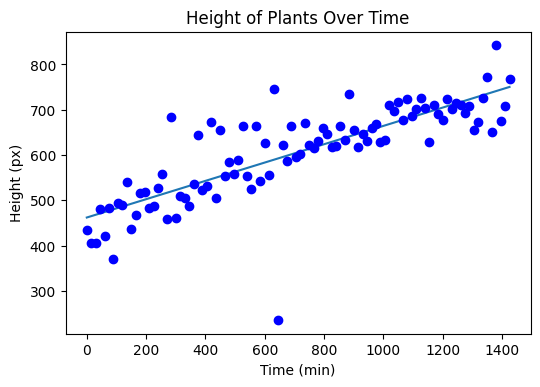

In [ ]:
x = time
y = list(a.values())

m, b = np.poly1d(np.polyfit(x, y, 1))
print(str(m) + " px/min")
matplotlib.pyplot.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
matplotlib.pyplot.plot(x, y, 'bo')
matplotlib.pyplot.xlabel("Time (min)")
matplotlib.pyplot.ylabel("Height (px)")
matplotlib.pyplot.title("Height of Plants Over Time")

## Issues
There are 2 big issues here:
1. The result is given by the value px/min. I don't have an idea of the scale of one pixel so this value is pretty useless so I would have to find some scale for the pixel to make this value meaningful. Right now I can't find an easy way to do this but some ideas I have are having a scale on each dish (which plantcv has a function for) or using the size of each petri dish to use as a conversion factor.
2. The skeletonization and catagorization of images is super inconsistent. I'd like to share some samples:



In [ ]:
# This one, unlike the one in the notebook, doesn't have paths for each leaf and instead wants to come out the middle, 
# which will affect the readings.
%%html
<img src='/nbextensions/FL-1_image00001_plot.png'/>

In [ ]:
# These two have paths that loop over themselves, counting some areas twice.
%%html
<img src='/nbextensions/FL-1_image00019_plot.png'/>
<img src='/nbextensions/FL-1_image00030_plot.png'/>

In [ ]:
#This one traces nonexistent plant material which I can only assume is because it is tracing a poorly thresholded "hair"
%%html
<img src='/nbextensions/FL-1_image00028_plot.png'/>

In [ ]:
# This one simply decided not to trace the roots of the plant.
%%html
<img src='/nbextensions/FL-1_image00043_plot.png'/>

## Conclusion
So the moral here is that the morphology functions of PlantCV does a reasonable job but there are major issues with thresholding that need to be solved to make a more accurate projection of growth. I hope this served as an inspiration so that a smart reader like you can build upon it. 